In [26]:
import numpy as np
import scipy.special  # Sigmoid activation function
import requests
import os
import imageio.v2 as imageio
import matplotlib.pyplot as plt

In [27]:
# ----------------------------
# 1. Dataset Retrieval Function
# ----------------------------
def download_file(url, filename):
    """Download a file from a URL if it does not exist locally."""
    if not os.path.exists(filename):
        r = requests.get(url, allow_redirects=True)
        with open(filename, "wb") as f:
            f.write(r.content)
        print(f"Downloaded: {filename}")
    else:
        print(f"File already exists: {filename}")

# URLs for MNIST dataset
mnist_train_url = "http://54.243.252.9/engr-1330-psuedo-course/CECE-1330-PsuedoCourse/6-Projects/P-ImageClassification/mnist_train.csv"
mnist_test_url = "http://54.243.252.9/engr-1330-psuedo-course/CECE-1330-PsuedoCourse/6-Projects/P-ImageClassification/mnist_test.csv"

# Download datasets
download_file(mnist_train_url, "mnist_train.csv")
download_file(mnist_test_url, "mnist_test.csv")

File already exists: mnist_train.csv
File already exists: mnist_test.csv


In [28]:
# ----------------------------
# 2. Neural Network Class
# ----------------------------
class NeuralNetwork:
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate, verbose=True):
        self.inodes = input_nodes
        self.hnodes = hidden_nodes
        self.onodes = output_nodes
        self.lr = learning_rate
        self.verbose = verbose
        
        # Initialize weight matrices with values between -0.5 and 0.5
        self.wih = (np.random.rand(self.hnodes, self.inodes) - 0.5)
        self.who = (np.random.rand(self.onodes, self.hnodes) - 0.5)
        
        # Activation function: Sigmoid
        self.activation_function = lambda x: scipy.special.expit(x)
    
    def train(self, inputs_list, targets_list):
        """Train the neural network using backpropagation."""
        inputs = np.array(inputs_list, ndmin=2).T
        targets = np.array(targets_list, ndmin=2).T
        
        hidden_inputs = np.dot(self.wih, inputs)
        hidden_outputs = self.activation_function(hidden_inputs)
        
        final_inputs = np.dot(self.who, hidden_outputs)
        final_outputs = self.activation_function(final_inputs)
        
        output_errors = targets - final_outputs
        hidden_errors = np.dot(self.who.T, output_errors)
        
        self.who += self.lr * np.dot((output_errors * final_outputs * (1.0 - final_outputs)), hidden_outputs.T)
        self.wih += self.lr * np.dot((hidden_errors * hidden_outputs * (1.0 - hidden_outputs)), inputs.T)
        
    def query(self, inputs_list):
        """Query the network for predictions."""
        inputs = np.array(inputs_list, ndmin=2).T
        hidden_inputs = np.dot(self.wih, inputs)
        hidden_outputs = self.activation_function(hidden_inputs)
        final_inputs = np.dot(self.who, hidden_outputs)
        final_outputs = self.activation_function(final_inputs)
        return final_outputs

In [33]:
# ----------------------------
# 3. Helper Functions
# ----------------------------
def load_data(filename):
    """Load dataset from a CSV file."""
    with open(filename, 'r') as f:
        return f.readlines()

def normalize_inputs(all_values):
    """Normalize input values from 0-255 to a range of 0.01 to 1.00."""
    return (np.asarray(all_values[1:], dtype=np.float64) / 255.0 * 0.99) + 0.01

def train_network(model, data, epochs=1, manual_lr_decay=True):
    """Train the neural network over multiple epochs."""
    for _ in range(epochs):
        for record in data:
            all_values = record.split(',')
            inputs = normalize_inputs(all_values)
            targets = np.zeros(model.onodes) + 0.01
            targets[int(all_values[0])] = 0.99
            model.train(inputs, targets)
        if manual_lr_decay:
            model.lr *= 0.9  # Manual learning rate scaling
    if model.verbose:
        print("Training complete!")

def evaluate_network(model, data):
    """Evaluate the model on test data."""
    scorecard = []
    for record in data:
        all_values = record.split(',')
        correct_label = int(all_values[0])
        inputs = normalize_inputs(all_values)
        outputs = model.query(inputs)
        label = np.argmax(outputs)
        scorecard.append(1 if label == correct_label else 0)
    accuracy = sum(scorecard) / len(scorecard)
    print(f"Model Accuracy: {accuracy * 100:.2f}%")

def classify_and_display_image(model, image_path):
    """Classify a new image and display it with the predicted label."""
    img_array = imageio.imread(image_path, mode='F')
    img_array = np.max(img_array) - img_array  # Invert colors
    img_data = (img_array / 255.0 * 0.99) + 0.01
    output = model.query(img_data.flatten())
    label = np.argmax(output)
    
    plt.imshow(img_array, cmap='Greys')
    plt.title(f"Predicted Label: {label}")
    plt.show()
    return label

In [30]:
# ----------------------------
# 4. Model Initialization & Training
# ----------------------------
input_nodes = 784  # 28x28 pixels
hidden_nodes = 110  # Intermediate hidden layer size
output_nodes = 10  # 10 classification labels
learning_rate = 0.1

# Create neural network instance
n = NeuralNetwork(input_nodes, hidden_nodes, output_nodes, learning_rate, verbose=True)

# Load training and test data
training_data = load_data("mnist_train.csv")
test_data = load_data("mnist_test.csv")

In [31]:
# Train the network
train_network(n, training_data, epochs=3)

Training complete!


In [32]:
# Evaluate performance
evaluate_network(n, test_data)

Model Accuracy: 96.60%


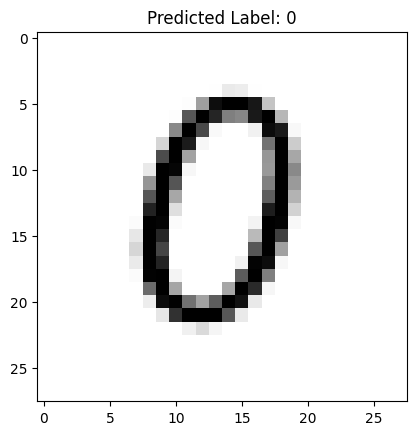

np.int64(0)

In [35]:
classify_and_display_image(n, "./image_src/MyZero.png")